In [7]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [8]:
# import libraries
import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
# import tensortools as tt
# import pywt
# import scaleogram as scg
import scipy
import scipy.signal
import pandas as pd

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

# import torch
# import torch.cuda

# import mtaper_specgram
# import test_function

In [9]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

In [10]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

# import mtaper_specgram

In [11]:
# sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
from bmi_idap.helpers.getVideoDirectoryProperties import getVideoDirectoryProperties

In [12]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

coding_env


In [13]:
%matplotlib notebook

In [14]:
### find version of openCV
# script currently works with v4.4.0
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# print(cv2.getBuildInformation())

# ### find version of pytorch
# print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

OpenCV version: 4.5.1
Autodetected operating system: Windows. Using "\\" for directory slashes


In [15]:
## == IMPORT DATA ==

## import S2p data

dir_s2p = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 11_20_N\20200325\suite2p\plane0'

F = np.load(f'{dir_s2p}{slash_type}F.npy')
Fneu = np.load(f'{dir_s2p}{slash_type}Fneu.npy')
iscell = np.load(f'{dir_s2p}{slash_type}iscell.npy')
ops = np.load(f'{dir_s2p}{slash_type}ops.npy', allow_pickle=True)
spks = np.load(f'{dir_s2p}{slash_type}spks.npy')
stat = np.load(f'{dir_s2p}{slash_type}stat.npy', allow_pickle=True)

num_frames_S2p = F.shape[1]

In [10]:
## == IMPORT DATA ==

## Import ROI Classifier data

dir_ROIClassifier = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/'

IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)


<IPython.core.display.Javascript object>


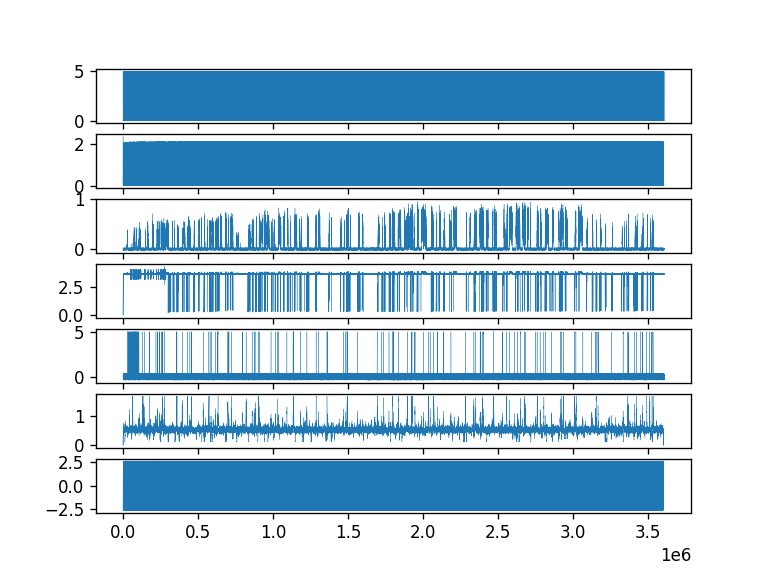

In [11]:
### import wavesurfer data

dir_ws = r'/media/rich/bigSSD RH/res2p/wavesurfer data/round 4 experiments/mouse 11.5/20210112'
fileName_ws = 'day0_0001.h5'

data_as_dict = pywavesurfer.ws.loadDataFile(filename=f'{dir_ws}{slash_type}{fileName_ws}', format_string='double' )
ws_data = data_as_dict[f'{list(data_as_dict.keys())[1]}']['analogScans']

fig = plt.figure()
for ii in range(ws_data.shape[0]):
    subplot_size = int(str(ws_data.shape[0]) + str(1) + str(ii+1))
    ax1 = fig.add_subplot(subplot_size)
    plt.plot(ws_data[ii,:] , linewidth=0.2)

In [12]:
### import camera GPIO pin signals
from concurrent import futures
import tqdm
from tqdm import trange

dir_cameraVidsForGPIO = r'F:\RH_Local\Rich data\camera data\test'
fileName_prefix_cameraVidsForGPIO = 'test5'
fileName_suffix_cameraVidsForGPIO = '.avi'

tic = time.time()

path_vid_allFiles , vid_height , vid_width , numFrames_total_rough , Fs_camera = getVideoDirectoryProperties.getVideoDirectoryProperties(
        1 , dir_cameraVidsForGPIO , fileName_prefix_cameraVidsForGPIO , fileName_suffix_cameraVidsForGPIO , [] , slash_type , 1)

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\RH_Local\\Rich data\\camera data\\test'

In [12]:
vid = imageio.get_reader(path_vid_allFiles[0],  'ffmpeg')

metadata = vid.get_meta_data()
print(metadata)

def get_pixels_topLeft_chunk(iter_vid):

    vid = imageio.get_reader(path_vid_allFiles[iter_vid],  'ffmpeg')

    metadata = vid.get_meta_data()
    upper_limit_on_number_of_frames = np.uint64((Fs_camera * metadata['duration'])*1.1)
    num_of_topLeft_pixels_to_extract = 16
    pixels_topLeft_chunk = np.ones((upper_limit_on_number_of_frames , num_of_topLeft_pixels_to_extract)) * np.nan

    for iter, im in enumerate(vid):
        pixels_topLeft_chunk[iter , :] = im[0,0:num_of_topLeft_pixels_to_extract,0].reshape((1,num_of_topLeft_pixels_to_extract))
        
#         new_frame_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # convert to grayscale
#         cv2.imshow('test',new_frame_gray)
#         cv2.waitKey(1)
#         k = cv2.waitKey(1) & 0xff
#         if k == 27 : break
                
    pixels_topLeft_chunk = pixels_topLeft_chunk[np.isnan(pixels_topLeft_chunk[:,0])==0 , :]


    print(f'FINISHED vid #: {iter_vid}')

    return pixels_topLeft_chunk

executer = futures.ThreadPoolExecutor(max_workers = multiprocessing.cpu_count())
pixels_topLeft_chunk_list = list(executer.map(get_pixels_topLeft_chunk , list(np.arange(len(path_vid_allFiles)))))
executer.shutdown()

# p = Pool(multiprocessing.cpu_count())  # where the magic acutally happens
# pixels_topLeft_chunk_list = p.map(get_pixels_topLeft_chunk , list(np.arange(len(path_vid_allFiles))))
# 
# p.close()
# p.terminate()
# p.join()


len(pixels_topLeft_chunk_list)
for ii in range(len(pixels_topLeft_chunk_list)):
    if ii == 0:
        pixels_topLeft = pixels_topLeft_chunk_list[ii]
    else:
        pixels_topLeft = np.concatenate((pixels_topLeft , pixels_topLeft_chunk_list[ii]) , axis=0)
        
signal_GPIO = pixels_topLeft[:,4]

print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

plt.figure()
plt.plot(signal_GPIO)


# np.save(f'D:\\res2p\\Camera data\\round 4 experiments\\mouse 6.28\\20200815\\pixels_topLeft.npy' , pixels_topLeft)

{'plugin': 'ffmpeg', 'nframes': inf, 'ffmpeg_version': '4.2.2 built with gcc 9.2.1 (GCC) 20200122', 'codec': 'rawvideo', 'pix_fmt': 'gray', 'fps': 0, 'source_size': (640, 480), 'size': (640, 480), 'duration': 187.99}


TypeError: 'module' object is not callable

In [13]:
### save signal_GPIO
dir_save = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210112/cam3'
name_save = 'signal_GPIO'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , signal_GPIO)

In [13]:
### load signal_GPIO
### save signal_GPIO
dir_load = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210112/cam1'
name_load = 'signal_GPIO'
path_load = f'{dir_load}{slash_type}{name_load}.npy'

signal_GPIO = np.load(path_load)

In [14]:
### import the face-rhythm factors

# dir_faceRhythm = r'F:\RH_Local\Rich data\camera data\mouse 8.9b\20210109\cam2'
dir_faceRhythm = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210112/cam1'

fileName_faceRhythm = 'factors_np5.npy'
# fileName_faceRhythm = 'positions_new_sansOutliers.npy'
factors_faceRhythm = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

# fileName_faceRhythm = 'Sxx_allPixels_normFactor.npy'
# factors_faceRhythm_normFactor = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

In [22]:
# ### import the face-rhythm factors

# dir_faceRhythm = '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run4'
# fileName_faceRhythm = 'pca_temporalFactor.npy'

# pca_temporalFactor_faceRhythm = np.load(f'{dir_faceRhythm}{slash_type}{fileName_faceRhythm}' , allow_pickle=True)

<IPython.core.display.Javascript object>


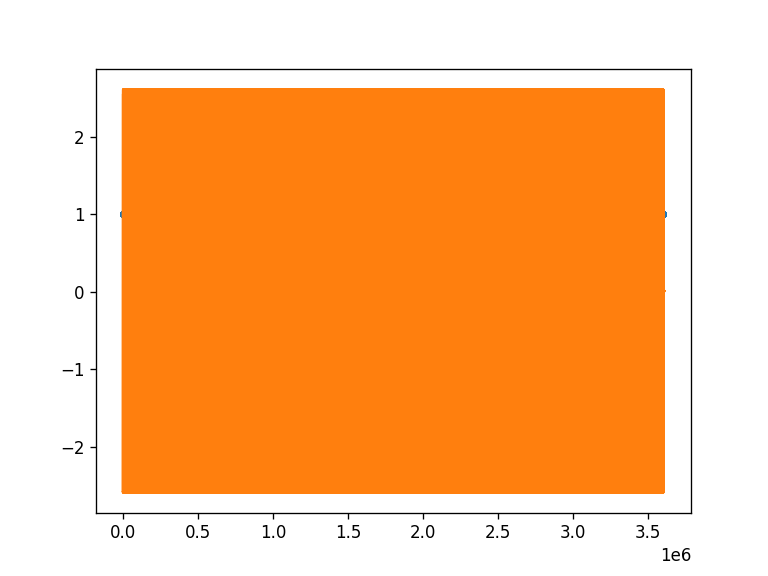

frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.365212962962964
total elapsed time: 0.49 seconds


In [15]:
## == ALIGN DATA ==

# Get ws frame times in ws time. Everything should be aligned to ws frame times (S2pInd)

# Outputs:
# - ws_YGalvoFlybacks_bool_wsTime
# - ws_frameTimes_wsTime   ***

tic = time.time()
ws_YGalvoFlybacks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[6,:]) < -1)) > 0.5

ws_frameTimes_wsTime = np.array(np.where(ws_YGalvoFlybacks_bool_wsTime))[0,:]
ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1]

plt.figure()
plt.plot(ws_frameTimes_wsTime,np.ones(len(ws_frameTimes_wsTime)),'.')
plt.plot(ws_data[6,:])
print(f'frames in scanimage movie = {num_frames_S2p}')
print(f'frames from ws galvo extraction movie = {ws_frameTimes_wsTime.shape[0]}')

ws_samples_per_S2p_frame_rough = (ws_frameTimes_wsTime[-1] - ws_frameTimes_wsTime[0]) / num_frames_S2p
print(f'number of wavesurfer samples per imaging frame:  {ws_samples_per_S2p_frame_rough}')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


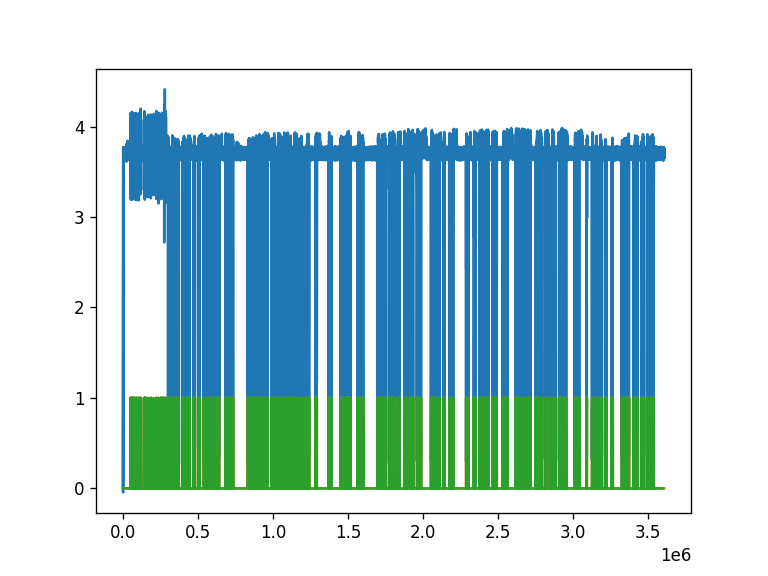

total elapsed time: 5.9 seconds


In [16]:
## Get lick times in S2p ind

# Outputs:
# - ws_licks_bool_wsTime
# - ws_licks_bool_S2pInd
# - ws_lickTimes_S2pInd   ***

tic = time.time()
ws_licks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[3,:]) < -0.2)) > 0.5

ws_licks_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_licks_bool_S2pInd[frame_num] = sum(ws_licks_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_lickTimes_S2pInd = np.array(np.where(ws_licks_bool_S2pInd))

plt.figure()
plt.plot(ws_data[3,:])
plt.plot(ws_licks_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_licks_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


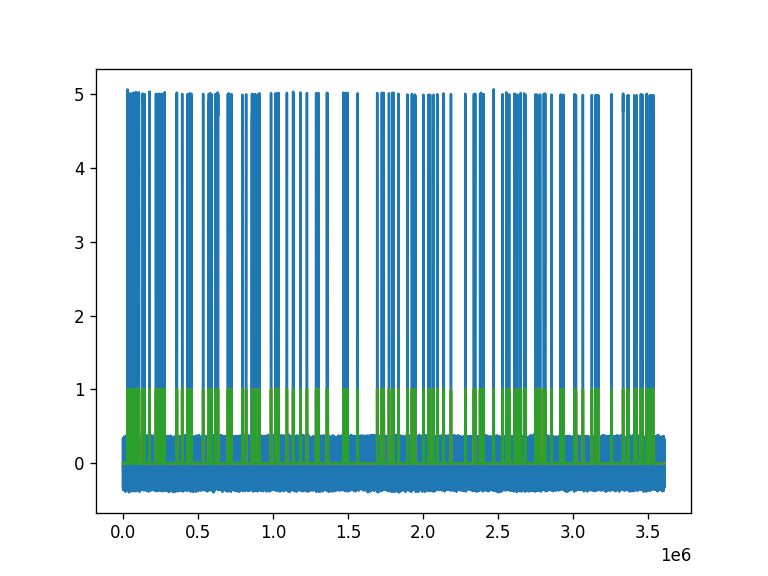

total elapsed time: 5.68 seconds


In [20]:
## Get reward delivery times in S2p ind

# Outputs:
# - ws_rewards_bool_wsTime
# - ws_rewards_bool_S2pInd
# - ws_rewardTimes_S2pInd   ***

tic = time.time()
ws_rewards_bool_wsTime = np.diff(np.int8(np.diff(ws_data[4,:]) > 1)) > 0.5


ws_rewards_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_rewards_bool_S2pInd[frame_num] = sum(ws_rewards_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_rewardTimes_S2pInd = np.array(np.where(ws_rewards_bool_S2pInd))

plt.figure()
plt.plot(ws_data[4,:])
plt.plot(ws_rewards_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_rewards_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [22]:
# np.double(ws_data[0,:].shape)/1000
# ws_data[0,int(987.5*1000):int(989*1000)]=0

<IPython.core.display.Javascript object>


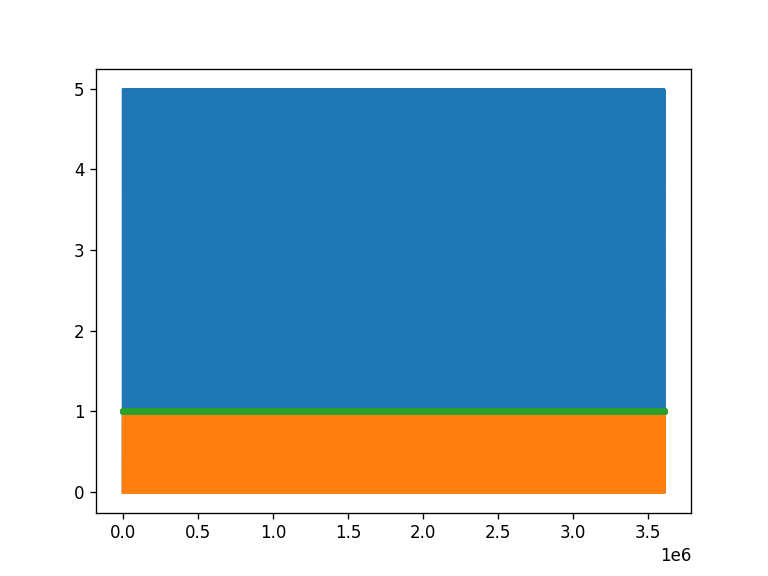

total elapsed time: 0.25 seconds


In [19]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - ws_camSignal_times

tic = time.time()
ws_camSignal_bool_wsTime = np.abs(np.hstack(([0] , np.diff(ws_data[0,:])))) > 1

ws_camSignal_wsTimes = np.where(ws_camSignal_bool_wsTime)[0]

plt.figure()
plt.plot(ws_data[0,:]);
plt.plot(ws_camSignal_bool_wsTime);
plt.plot(ws_camSignal_wsTimes, np.ones(len(ws_camSignal_wsTimes)).T ,'.');
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


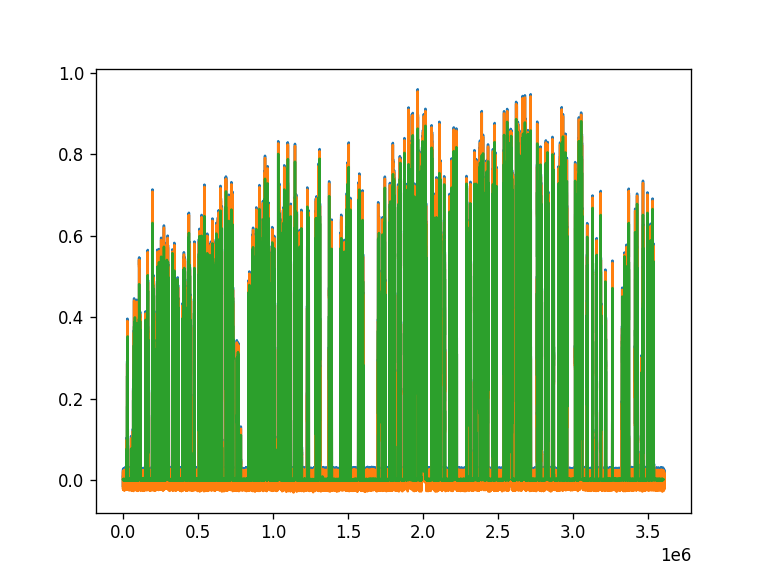

total elapsed time: 0.86 seconds


In [27]:
## Convert treadmill signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_treadmill_wsTime = ws_data[2,:] - np.percentile(ws_data[2,:], 20)

ws_treadmill_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_treadmill_S2pInd[frame_num] = sum(ws_treadmill_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_treadmill_S2pInd = ws_treadmill_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_treadmill_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_treadmill_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


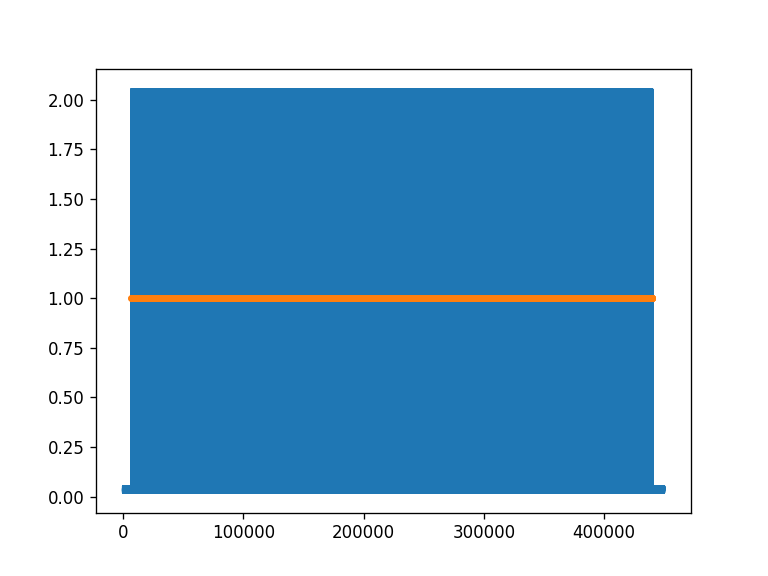

In [21]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - camera_camSignal_camTimes
# - camera_frames_wsTime ***

tic = time.time()
input_signal_GPIO = scipy.stats.zscore(np.double(signal_GPIO))

signal_GPIO_bool_camTime = np.abs(np.hstack(([0] , np.diff(input_signal_GPIO)))) > 1
# plt.figure()
# plt.plot(signal_GPIO_bool_camTime)

signal_GPIO_camTimes = np.where(signal_GPIO_bool_camTime)[0]

plt.figure()
plt.plot(input_signal_GPIO+1);
# plt.plot(camera_camSignal_bool_camTime);
# plt.plot(np.diff(pixels_topLeft[:,8]));
plt.plot(signal_GPIO_camTimes, np.ones(len(signal_GPIO_camTimes)).T ,'.');

In [23]:
print(ws_camSignal_wsTimes.shape)
print(signal_GPIO_camTimes.shape)

(7220,)
(7220,)


<IPython.core.display.Javascript object>


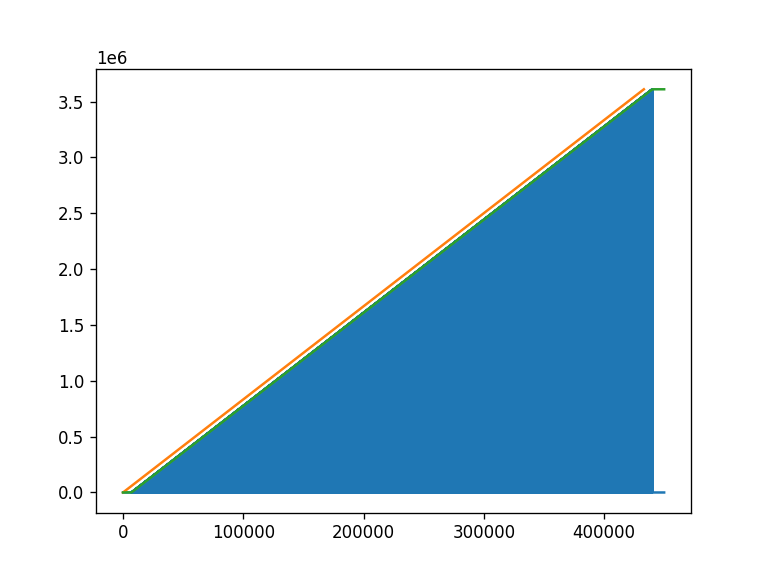

<IPython.core.display.Javascript object>


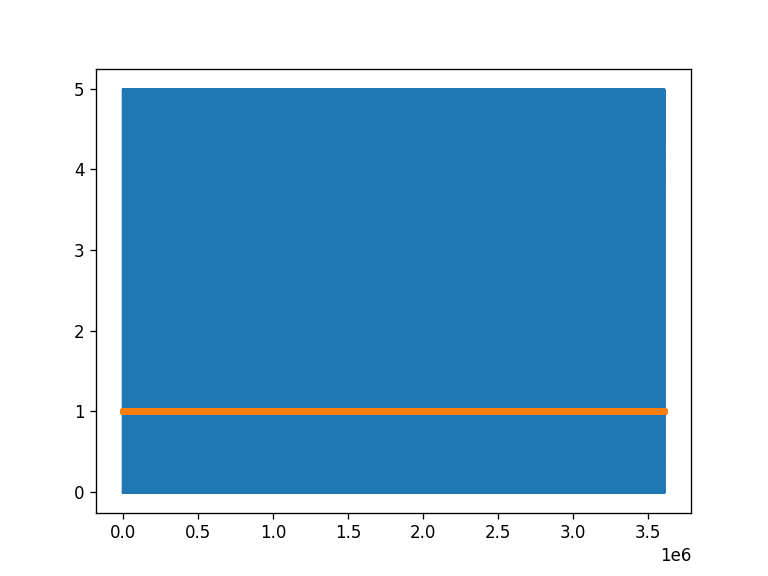

total elapsed time: 5.66 seconds


In [24]:
signal_GPIO_wsTimes = np.double(signal_GPIO_bool_camTime)
signal_GPIO_wsTimes[signal_GPIO_camTimes] = ws_camSignal_wsTimes
# signal_GPIO_wsTimes[signal_GPIO_camTimes] = crop_ws_camSignal_wsTimes
# plt.figure()
# plt.plot(signal_GPIO_wsTimes)

tmp = copy.deepcopy(signal_GPIO_wsTimes)
tmp[tmp==0] = np.nan
tmp = pd.DataFrame(tmp)
camera_frames_wsTimes = np.array(tmp.interpolate())
# plt.figure()
# plt.plot(camera_frames_wsTimes) 

tmp = copy.deepcopy(camera_frames_wsTimes)
tmp[np.isnan(tmp)] = 0
camera_frames_wsTimes_withLeadingZeros = np.int32(np.round(tmp))[:,0]
first_camFrame_camIdx = np.argmax(np.where(camera_frames_wsTimes_withLeadingZeros==0))+1
last_camFrame_camIdx = np.min(np.array(np.where(camera_frames_wsTimes_withLeadingZeros == np.max(camera_frames_wsTimes_withLeadingZeros))[0]))
camera_frames_wsTimes = camera_frames_wsTimes_withLeadingZeros[first_camFrame_camIdx:last_camFrame_camIdx]

plt.figure()
plt.plot(signal_GPIO_wsTimes)
plt.plot(camera_frames_wsTimes)
plt.plot(camera_frames_wsTimes_withLeadingZeros)

plt.figure()
plt.plot(ws_data[0,:])
plt.plot(camera_frames_wsTimes_withLeadingZeros , np.ones_like(camera_frames_wsTimes_withLeadingZeros) , '.')
# plt.plot(camera_frames_wsTimes , np.ones_like(camera_frames_wsTimes) , '.')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


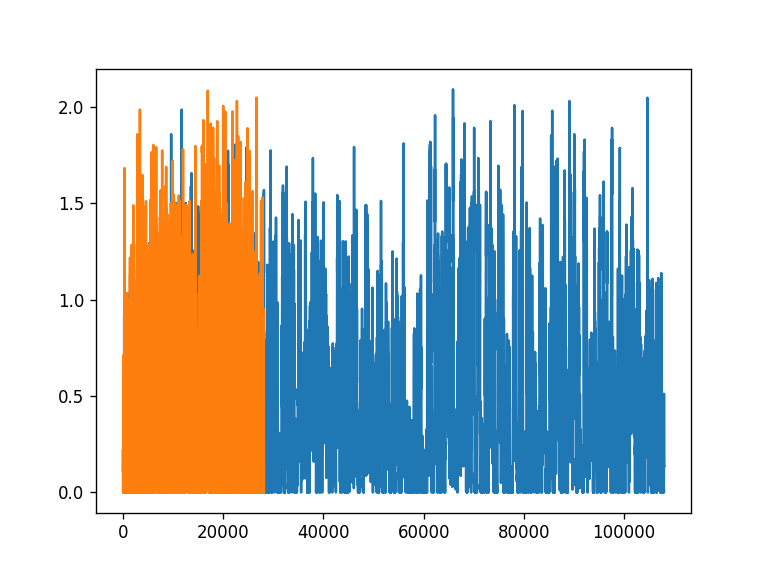

total elapsed time: 0.05 seconds


In [25]:
### resample factors_faceRhythm into ws and s2p times
# this script assumes that the GPIO sync trace has identical indexing as the video that was used for the factor decomposition (hopefully it's the same video)

tic = time.time()
temporalFactors_faceRhythm = factors_faceRhythm[2]
# temporalFactors_faceRhythm = factors_faceRhythm_normFactor
upsample_factor = signal_GPIO.shape[0] / temporalFactors_faceRhythm.shape[0]

temporalFactors_camFrameTimes = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , len(temporalFactors_faceRhythm) )))
temporalFactors_Idx_withinWS = [(temporalFactors_camFrameTimes >= first_camFrame_camIdx) * 
                                (temporalFactors_camFrameTimes <= last_camFrame_camIdx)]
temporalFactors_withinWS = temporalFactors_faceRhythm[tuple(temporalFactors_Idx_withinWS)]
temporalFactors_camFrameIdx_withinWS = temporalFactors_camFrameTimes[tuple(temporalFactors_Idx_withinWS)]
temporalFactors_wsIdx_withinWS = camera_frames_wsTimes_withLeadingZeros[temporalFactors_camFrameIdx_withinWS]

function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic' , axis=0)
first_s2pIdx_usableForTemporalFactors = np.min(np.where(ws_frameTimes_wsTime > np.min(temporalFactors_wsIdx_withinWS)))

temporalFactors_s2pInd = function_interp(ws_frameTimes_wsTime[first_s2pIdx_usableForTemporalFactors:])
temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors , temporalFactors_s2pInd.shape[1])) , temporalFactors_s2pInd) , axis=0)
temporalFactors_s2pInd[temporalFactors_s2pInd < 0] = 0


plt.figure()
plt.plot(temporalFactors_s2pInd[:,0])
plt.plot(temporalFactors_faceRhythm[:,0])
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


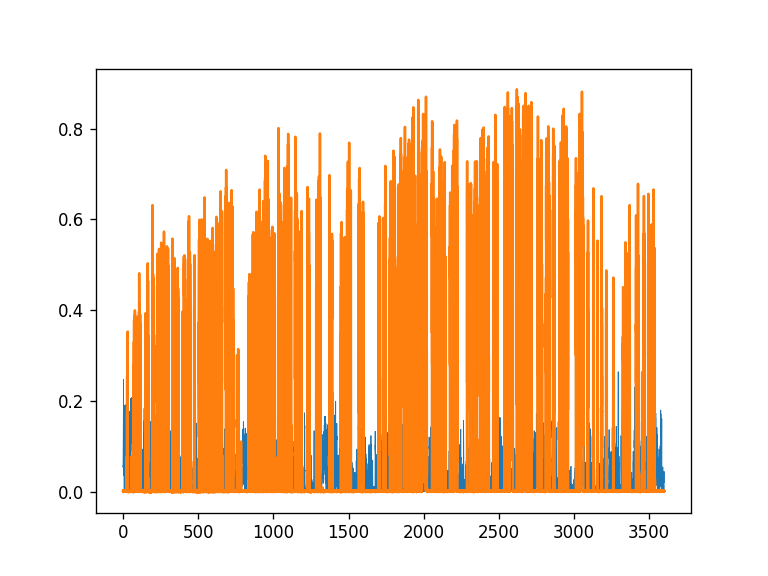

In [28]:
plt.figure()
plt.plot(np.arange(len(ws_treadmill_S2pInd))/30 , temporalFactors_s2pInd[:,1]/10 , linewidth=-.5)
plt.plot(np.arange(len(ws_treadmill_S2pInd))/30 , ws_treadmill_S2pInd)

In [27]:
# ### resample pca_temporalFactor_faceRhythm into ws and s2p times
# # this script assumes that the GPIO sync trace has identical indexing as the video that was used for the factor decomposition (hopefully it's the same video)

# tic = time.time()
# # temporalFactors_faceRhythm = pca_temporalFactor_faceRhythm[:,0]
# temporalFactors_faceRhythm = abs(temp_Sxx)
# upsample_factor = signal_GPIO.shape[0] / temporalFactors_faceRhythm.shape[0]

# temporalFactors_camFrameTimes = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , len(temporalFactors_faceRhythm) )))
# temporalFactors_Idx_withinWS = [(temporalFactors_camFrameTimes >= first_camFrame_camIdx) * 
#                                 (temporalFactors_camFrameTimes <= last_camFrame_camIdx)]
# temporalFactors_withinWS = temporalFactors_faceRhythm[tuple(temporalFactors_Idx_withinWS)]
# temporalFactors_camFrameIdx_withinWS = temporalFactors_camFrameTimes[tuple(temporalFactors_Idx_withinWS)]
# temporalFactors_wsIdx_withinWS = camera_frames_wsTimes_withLeadingZeros[temporalFactors_camFrameIdx_withinWS]

# # function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic' , axis=0)
# function_interp = scipy.interpolate.interp1d(temporalFactors_wsIdx_withinWS , temporalFactors_withinWS , kind='cubic')
# first_s2pIdx_usableForTemporalFactors = np.min(np.where(ws_frameTimes_wsTime > np.min(temporalFactors_wsIdx_withinWS)))

# temporalFactors_s2pInd = function_interp(ws_frameTimes_wsTime[first_s2pIdx_usableForTemporalFactors:])
# # temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors , temporalFactors_s2pInd.shape[1])) , temporalFactors_s2pInd) , axis=0)
# temporalFactors_s2pInd = np.concatenate((np.zeros((first_s2pIdx_usableForTemporalFactors)) , temporalFactors_s2pInd))
# # temporalFactors_s2pInd[temporalFactors_s2pInd < 0] = 0


# plt.figure()
# # plt.plot(temporalFactors_s2pInd[:,0])
# # plt.plot(temporalFactors_faceRhythm[:,0])
# plt.plot(temporalFactors_faceRhythm)
# plt.plot(temporalFactors_s2pInd)
# print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [ ]:
# downsample the DLC data into S2p indices

tic = time.time()
body_part_highConfidence_interp_S2pInd = np.zeros([len(ws_frameTimes_wsTime) , 
                                                   body_part_highConfidence_interp.shape[1] , 
                                                   body_part_highConfidence_interp.shape[2]])
body_part_highConfidence_interp_diff_S2pInd = np.zeros([len(ws_frameTimes_wsTime) , 
                                                        body_part_highConfidence_interp_diff.shape[1] , 
                                                        body_part_highConfidence_interp_diff.shape[2]])

for iter,val in enumerate(ws_frameTimes_wsTime):
    if np.mod(iter,10000) ==0:
        print(iter)
    if iter==0:
        body_part_highConfidence_interp_S2pInd[iter,:,:] = body_part_highConfidence_interp[
            camera_frames_wsTime[np.argmin(np.abs(camera_frames_wsTime_withLeadingZeros - val))],:,:]
        
        body_part_highConfidence_interp_diff_S2pInd[iter,:,:] = body_part_highConfidence_interp_diff[
            camera_frames_wsTime[np.argmin(np.abs(camera_frames_wsTime_withLeadingZeros - val))],:,:]

    else:
        body_part_highConfidence_interp_S2pInd[iter,:,:] = np.mean(np.squeeze(body_part_highConfidence_interp[np.where(((camera_frames_wsTime_withLeadingZeros > ws_frameTimes_wsTime[iter-1])
                                                                    * (camera_frames_wsTime_withLeadingZeros < ws_frameTimes_wsTime[iter]))[:,0]),:,:]) , axis=0)
        body_part_highConfidence_interp_diff_S2pInd[iter,:,:] = np.mean(np.squeeze(body_part_highConfidence_interp_diff[np.where(((camera_frames_wsTime_withLeadingZeros > ws_frameTimes_wsTime[iter-1])
                                                                   * (camera_frames_wsTime_withLeadingZeros < ws_frameTimes_wsTime[iter]))[:,0]),:,:]) , axis=0)
#         body_part_highConfidence_interp_S2pInd = np.concatenate((body_part_highConfidence_interp_S2pInd , tmp_position[None,:,:]) , axis=0)
#         body_part_highConfidence_interp_diff_S2pInd = np.concatenate((body_part_highConfidence_interp_diff_S2pInd , tmp_velocity[None,:,:]) , axis=0)

body_part_highConfidence_interp_diff_abs_S2pInd = np.abs(body_part_highConfidence_interp_diff_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [29]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 3.3 seconds


In [30]:
## Make rolling baseline subtraction
import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(60 * 30 * 10)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

100%|██████████| 108000/108000 [01:06<00:00, 1615.07it/s]


In [32]:
## == REGRESSION ANALYSIS

<IPython.core.display.Javascript object>


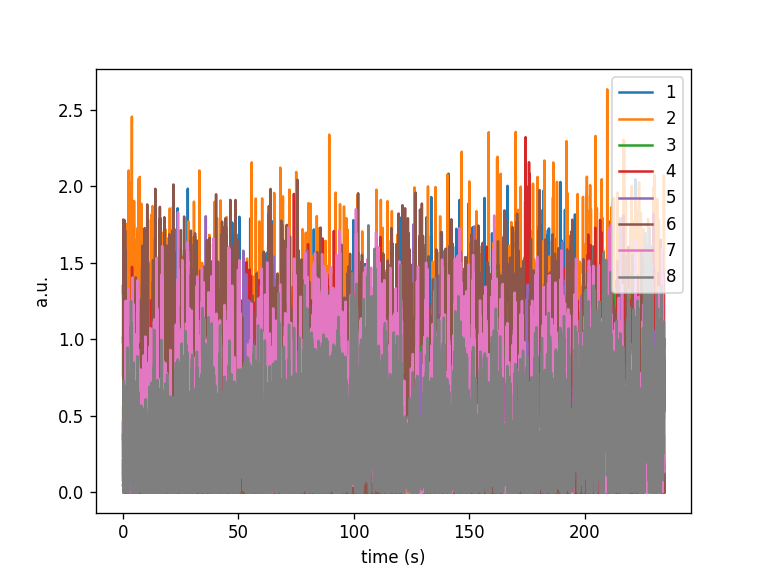

Text(0, 0.5, 'a.u.')

In [31]:
%matplotlib notebook

factors_toUse = factors_faceRhythm
modelRank = factors_toUse[0].shape[1]
## just for plotting in case 
if 'Fs' not in globals():
    Fs = 120

plt.figure()
# plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
# factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
factors_temporal = factors_toUse[2][:,:]
# factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,])
# plt.plot(factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

# plt.figure()
# # plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
# # factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
# factors_temporal = factors_toUse[2][:,:] * (np.mean(Sxx_allPixels_normFactor , axis=1)[:,None])
# # factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# # plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
# # plt.plot(factors_temporal[:,:])
# plt.legend(np.arange(modelRank)+1)
# plt.xlabel('time (s)')
# plt.ylabel('a.u.')

# plt.figure()
# plt.plot(freqs_Sxx , (factors_toUse[1][:,:]))
# # plt.plot(freqXaxis , (factors_toUse[1][:,:]))
# # plt.plot(f , (factors_toUse[1][:,:]))
# # plt.plot((factors_toUse[1][:,:]))
# plt.legend(np.arange(modelRank)+1)
# plt.xscale('log')
# plt.xlabel('frequency (Hz)')
# plt.ylabel('a.u.')
# # plt.xscale('log')

# plt.figure()
# plt.plot(factors_toUse[3][:,:])
# plt.legend(np.arange(modelRank)+1)
# plt.xlabel('x vs. y')
# plt.ylabel('a.u.')

# plt.figure()
# plt.plot(factors_toUse[0][:,:])
# plt.legend(np.arange(modelRank)+1)
# plt.xlabel('pixel number')
# plt.ylabel('a.u.')


# plt.figure()
# plt.imshow(np.single(np.corrcoef(factors_toUse[2][:,:].T)))

# input_dimRed = factors_toUse[2][:,:]
# # input_dimRed_meanSub = 
# pca = sk.decomposition.PCA(n_components=modelRank-2)
# # pca = sk.decomposition.FactorAnalysis(n_components=3)
# pca.fit(np.single(input_dimRed).transpose())
# output_PCA = pca.components_.transpose()
# # scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

# plt.figure()
# plt.plot(output_PCA[:,5])

<IPython.core.display.Javascript object>


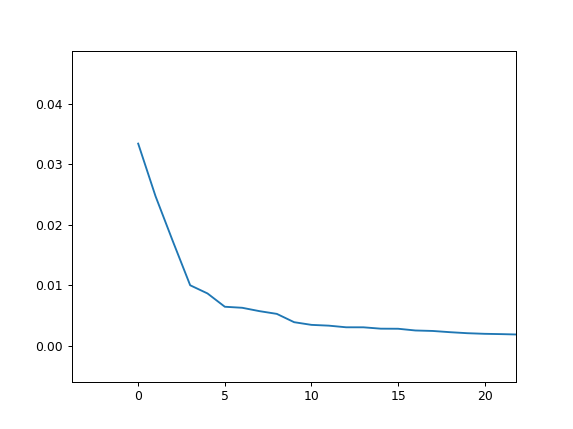

In [46]:
input_dimRed = F_zscore_roll[:,IsCell_ROIClassifier==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [48]:
output_PCA[:,1:].shape

(108000, 2220)

<IPython.core.display.Javascript object>


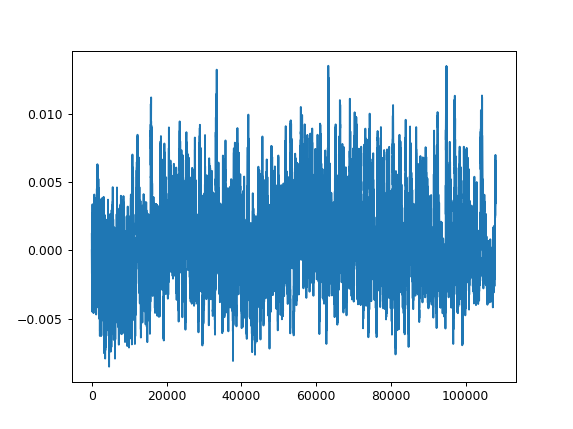

In [52]:
plt.figure()
plt.plot(output_PCA[:,4])

In [32]:
# num_factors = temporalFactors_s2pInd.shape[1]
num_factors = 8

R = np.zeros((num_factors , 1000))
for ii in range(100,1000,50):
# for ii in range(2,1000):
    # X_input = dFoF[IsCell_ROIClassifier==True,:].T
    # X_input = dFoF.T
    # X_input = output_PCA[:,np.array([0,1,1000])]
    X_input = output_PCA[:,:ii+1]
    y_input = temporalFactors_s2pInd
    # y_input = ws_licks_bool_S2pInd

    X = np.hstack((np.ones(spks.shape[1]).reshape(spks.shape[1],1) ,
                   np.linspace(0,1,spks.shape[1])[:,None],
                   X_input))

    y_reconstructed = np.zeros((X.shape[0] , num_factors))
    y = np.zeros((X.shape[0] , num_factors))
#     R = np.zeros((num_factors))
    for iter_factor in range(num_factors):
    # for iter_factor in np.array([5]):

    #     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor] ** (1/2)
    #     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor]
        y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3)) ** (1/2)
    #     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3))
    #     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input , 101 , 3)) ** (1/2)
    #     y[:,iter_factor] = abs(y_input) ** (1/2)

        X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
            X, y[:,iter_factor], test_size=0.3, random_state=0)

        theta = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)
        theta_lg = theta[2:]

        y_train_output = X_train @ theta
        R_train = (np.corrcoef(y_train_output, y_train))[1,0]
#         print(f'iter: {iter_factor} , train R: {R_train}')

        y_test_output = X_test @ theta
        R[iter_factor,ii] = (np.corrcoef(y_test_output, y_test))[1,0]
#         print(f'iter: {iter_factor} , test  R: {R[iter_factor]}')

        y_reconstructed[:,iter_factor] = X @ theta

NameError: name 'output_PCA' is not defined

<IPython.core.display.Javascript object>


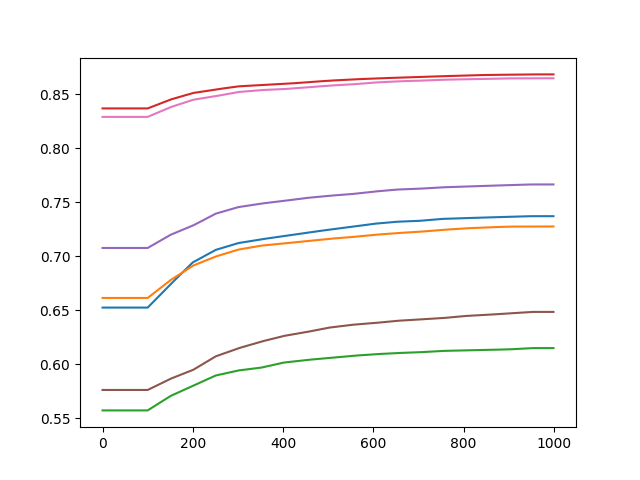

In [38]:
R[R==0] = np.nan
def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan

    return filled

for ii in range(R.shape[0]):
    R[ii,:] = interpolate_gaps(R.T[:,ii])
plt.figure()
plt.plot(R.T)

<IPython.core.display.Javascript object>


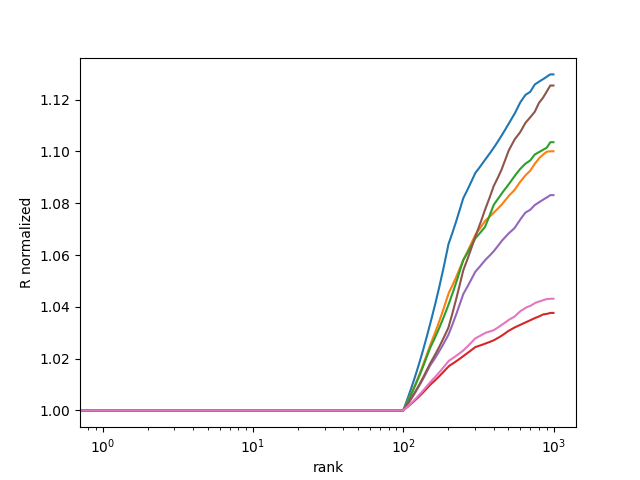

<IPython.core.display.Javascript object>


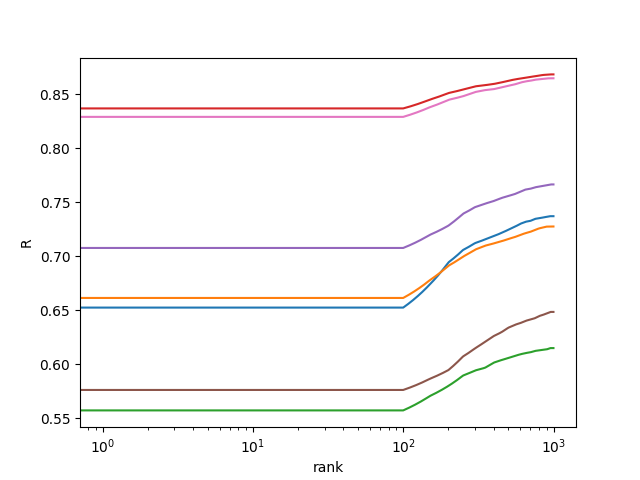

In [39]:
R_plot = np.vstack((R , np.nan*np.zeros(R.shape[1])[None,:])).T
plt.figure()
plt.plot(R_plot / R_plot[1,:][None,:])
plt.ylabel('R normalized')
plt.xlabel('rank')
# plt.plot(R.T)
plt.xscale('log')

plt.figure()
plt.plot(R_plot)
plt.ylabel('R')
plt.xlabel('rank')
# plt.plot(R.T)
plt.xscale('log')

In [163]:
y_input.shape

(108000,)

<IPython.core.display.Javascript object>


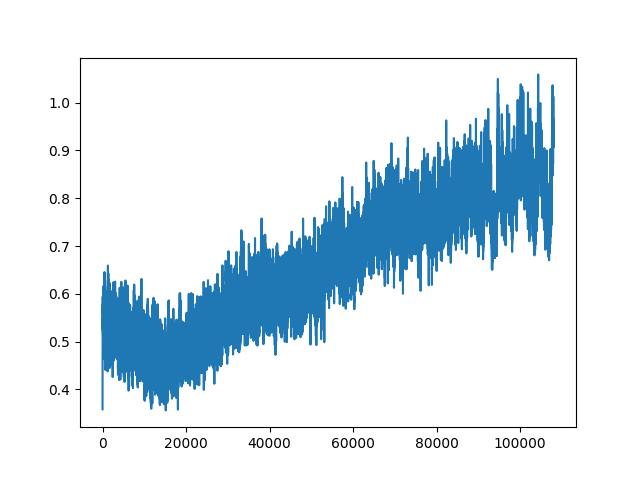

In [57]:
plt.figure()
plt.plot(np.mean(dFoF[IsCell_ROIClassifier==True,:].T , axis=1)[:,None])

iter: 0 , train R: 0.9276939380555234
iter: 0 , test  R: 0.9264182435177224


<IPython.core.display.Javascript object>


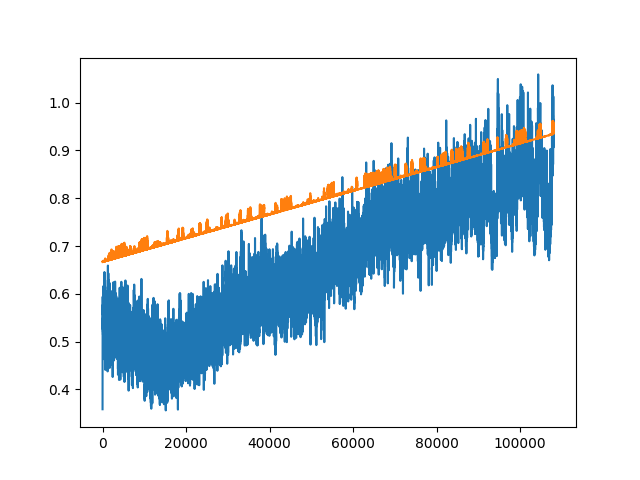

In [68]:
# num_factors = temporalFactors_s2pInd.shape[1]
num_factors = 1

y_input = np.mean(dFoF[IsCell_ROIClassifier==True,:].T , axis=1)[:,None]
# X_input = dFoF.T
# X_input = output_PCA[:,np.array([0,1,1000])]
# X_input = output_PCA[:,:]
# X_input = temporalFactors_s2pInd
# y_input = ws_licks_bool_S2pInd
X_input = ws_treadmill_S2pInd[:,None]

X = np.hstack((np.ones(spks.shape[1]).reshape(spks.shape[1],1) ,
               np.linspace(0,1,spks.shape[1])[:,None],
               X_input))

y_reconstructed = np.zeros((X.shape[0] , num_factors))
y = np.zeros((X.shape[0] , num_factors))
R = np.zeros((num_factors))
for iter_factor in range(num_factors):
# for iter_factor in np.array([5]):

#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor] ** (1/2)
#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor]
    y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3)) ** (1/2)
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3))
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input , 101 , 3)) ** (1/2)
#     y[:,iter_factor] = abs(y_input) ** (1/2)

    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
        X, y[:,iter_factor], test_size=0.3, random_state=0)

    theta = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)
    theta_lg = theta[2:]

    y_train_output = X_train @ theta
    R_train = (np.corrcoef(y_train_output, y_train))[1,0]
    print(f'iter: {iter_factor} , train R: {R_train}')
    
    y_test_output = X_test @ theta
    R[iter_factor] = (np.corrcoef(y_test_output, y_test))[1,0]
    print(f'iter: {iter_factor} , test  R: {R[iter_factor]}')
    
    y_reconstructed[:,iter_factor] = X @ theta

plt.figure()
plt.plot(y_input)
plt.plot(y_reconstructed)

In [69]:
test = np.random.rand(6,6)
test[[True, False, True, False, True, False] , [2,3]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (2,) 

In [79]:
np.sum(idx_nonRunning)
temporalFactors_s2pInd.shape
# plt.figure()
# plt.plot(ws_treadmill_S2pInd)

(108000, 8)

<IPython.core.display.Javascript object>


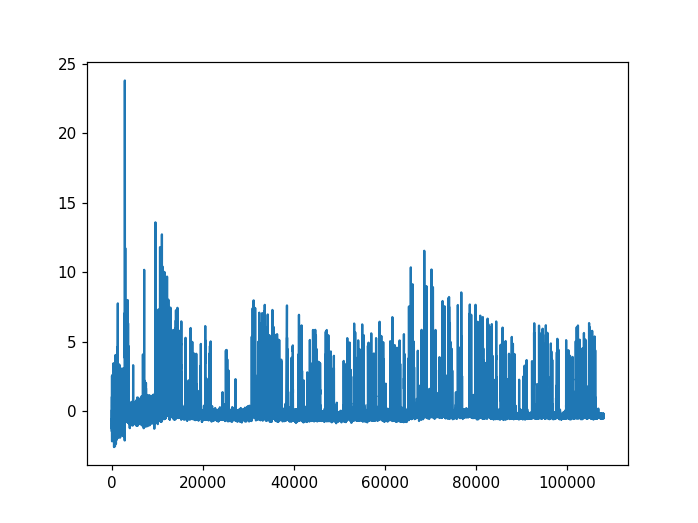

In [63]:
plt.figure()
# plt.imshow(X_input , aspect='auto')
plt.plot(F_zscore_roll[:,2])
# plt.plot(F[0,:].T)
# IsCell_ROIClassifier

In [142]:
idx_nonRunning.shape

(108000,)

<IPython.core.display.Javascript object>


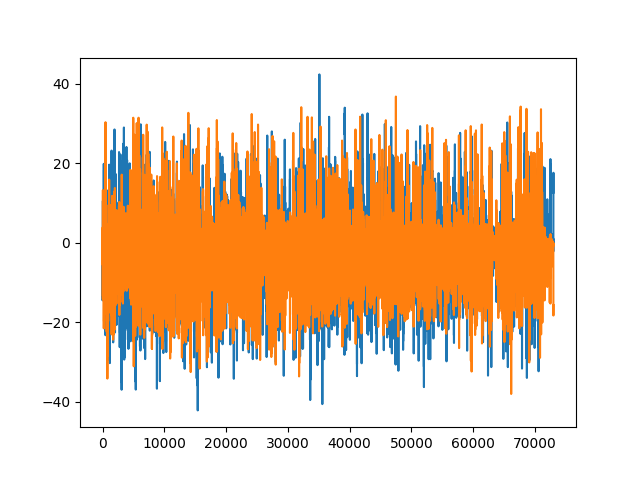

In [112]:
plt.figure()
plt.plot(temporalFactors_s2pInd[idx_nonRunning,:])

In [142]:
np.array([.5, 1])[:,None].shape

(2, 1)

In [147]:
X_input.shape

(73000, 1286)

<IPython.core.display.Javascript object>


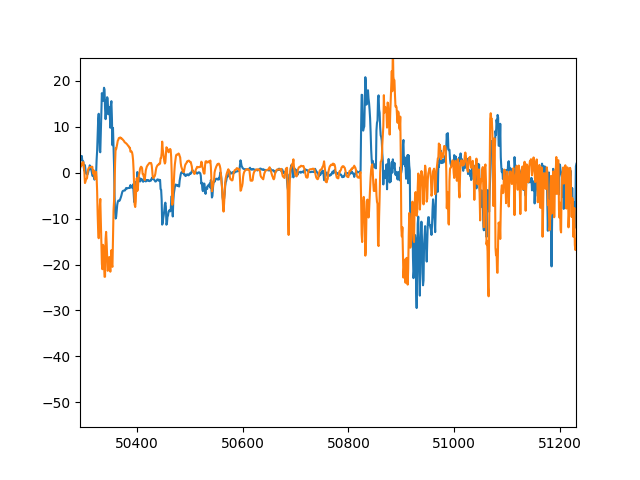

In [201]:
plt.figure()
plt.plot(temporalFactors_s2pInd)

In [38]:
# import sklearn.linear_model
from catboost import CatBoostRegressor


# num_factors = temporalFactors_s2pInd.shape[1]
num_factors = 8

# idx_nonRunning = np.where(ws_treadmill_S2pInd[75000:] < 0.005)[0]
# idx_nonRunning = np.where(ws_treadmill_S2pInd[np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))] < 0.005)[0]
# idx_nonRunning = ws_treadmill_S2pInd < 0.005
idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0
# idx_nonRunning = np.where(idx_nonRunning[tmp])[0]
# idx_nonRunning = np.where(idx_nonRunning[~np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))])[0]

# X_input = dFoF[IsCell_ROIClassifier==True,:].T
# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll
X_input = X_input[idx_nonRunning,:]
# X_input = dFoF.T
# X_input = output_PCA[:,np.array([0,1,1000])]
# X_input = output_PCA[:,:]
# y_input = temporalFactors_s2pInd
# y_input = scipy.signal.savgol_filter( temporalFactors_s2pInd[idx_nonRunning,:] , 21 , 3 , axis=0 )
y_input = temporalFactors_s2pInd[idx_nonRunning,:] 
# y_input[y_input<0] = 0
# y_input = y_input**(1/3)
# y_input = ws_licks_bool_S2pInd

# X = np.hstack((np.ones(spks.shape[1]).reshape(spks.shape[1],1) ,
#                np.linspace(0,1,spks.shape[1])[:,None],
#                X_input))
# X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))

# y_reconstructed_FF = np.zeros((X.shape[0] , num_factors))
y_reconstructed_FF = np.zeros((F_zscore_roll.shape[0] , num_factors))
y = np.zeros((X.shape[0] , num_factors))
R = np.zeros((num_factors))
theta_FF = np.ones((X_input.shape[1]+1,num_factors))
for iter_factor in range(num_factors):
# for iter_factor in np.array([5]):

#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor] ** (1/2)
#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor]
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3)) ** (1/2)
    y[:,iter_factor] = y_input[:,iter_factor]
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3))
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input , 101 , 3)) ** (1/2)
#     y[:,iter_factor] = abs(y_input) ** (1/2)

    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
        X, y[:,iter_factor], test_size=0.3, random_state=0)
    
#     ### SKLEARN regression
#     clf = sklearn.linear_model.Lasso(alpha=1e-1)
#     clf.fit(X_train , y_train )
#     theta_FF[:,iter_factor] = clf.coef_

#     ### CATBOOST regression
#     model = CatBoostRegressor(iterations=2000,
# #                               learning_rate=1,
# #                               depth=2,
#                               task_type="GPU",
#                               devices='0:1')
#     model.fit(X_train, y_train)
#     y_train_output = model.predict(X_train)
#     y_test_output = model.predict(X_test)

    theta_FF[:,iter_factor] = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

    y_train_output = X_train @ theta_FF[:,iter_factor]
    R_train = (np.corrcoef(y_train_output, y_train))[1,0]
    print(f'iter: {iter_factor} , train R: {R_train}')
    
    y_test_output = X_test @ theta_FF[:,iter_factor]
    R[iter_factor] = (np.corrcoef(y_test_output, y_test))[1,0]
    print(f'iter: {iter_factor} , test  R: {R[iter_factor]} , test  R^2: {R[iter_factor]**2}')
    
#     y_reconstructed[:,iter_factor] = X @ theta_FF[:,iter_factor]
    y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll[:,IsCell_ROIClassifier==True])) @ theta_FF[:,iter_factor]
#     y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll)) @ theta_FF[:,iter_factor]

iter: 0 , train R: 0.6466801321436726
iter: 0 , test  R: 0.6182052116577955 , test  R^2: 0.38217768372085975
iter: 1 , train R: 0.6484042321732264
iter: 1 , test  R: 0.6198380763678671 , test  R^2: 0.3841992409154179
iter: 2 , train R: 0.8183115129459162
iter: 2 , test  R: 0.8120748837066296 , test  R^2: 0.659465616747136
iter: 3 , train R: 0.5928578231971573
iter: 3 , test  R: 0.5670763622550593 , test  R^2: 0.32157560062843127
iter: 4 , train R: 0.48101422916231007
iter: 4 , test  R: 0.42887269445116294 , test  R^2: 0.18393178804580057
iter: 5 , train R: 0.8188837281724433
iter: 5 , test  R: 0.8116054420944085 , test  R^2: 0.6587033936372604
iter: 6 , train R: 0.6581107334389201
iter: 6 , test  R: 0.6353471496734301 , test  R^2: 0.403666000598152
iter: 7 , train R: 0.6210254467940486
iter: 7 , test  R: 0.6006192489323364 , test  R^2: 0.3607434821880439


<IPython.core.display.Javascript object>


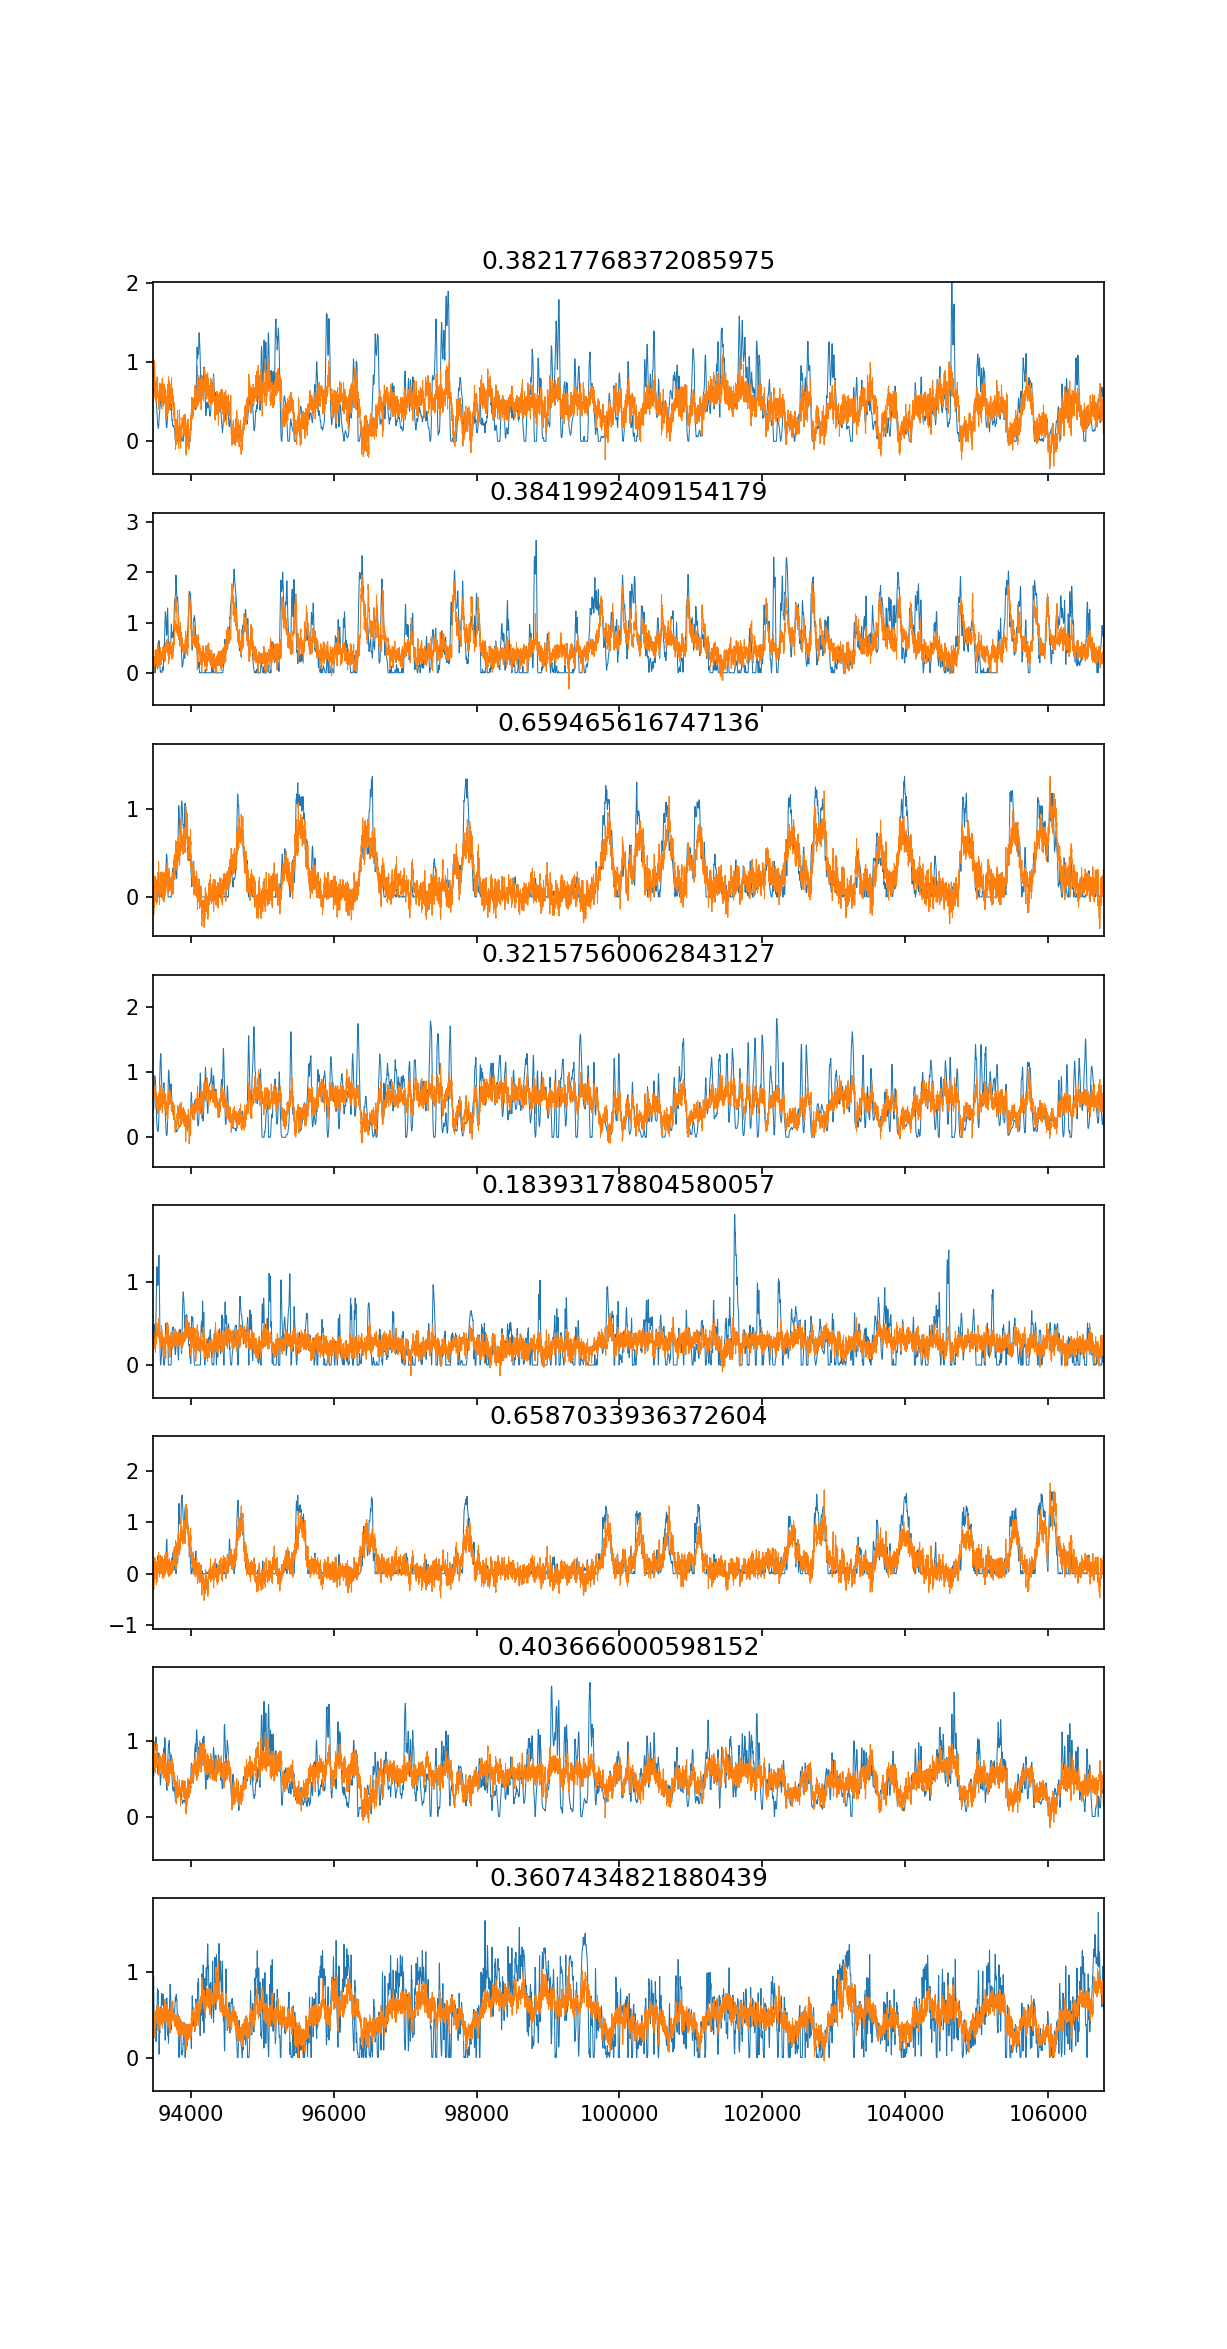

In [52]:
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
#     plt.subplot(num_factors , 1, iter_factor+1)
#     subplot_size = int(str(num_factors) + str(1) + str(iter_factor+1))
#     axs = fig.add_subplot(subplot_size)
#     plt.plot(scipy.signal.savgol_filter( temporalFactors_s2pInd[:,iter_factor] ,21,3 ), linewidth=0.5)
    axs[iter_factor].plot(temporalFactors_s2pInd[:,iter_factor] , linewidth=0.5)
##     plt.plot(y_reconstructed_FF[:,iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(scipy.signal.savgol_filter( y_reconstructed_FF[:,iter_factor] ,5,3 ) , linewidth=0.5)
#     plt.plot(ws_treadmill_S2pInd / .2 , linewidth=1.0)
#     plt.plot(ws_licks_bool_S2pInd / .4 , linewidth=1.0)
    axs[iter_factor].set_title(R[iter_factor]**2)

treadmill, train R: 0.7793351797937388
treadmill, test  R: 0.7693474367253142
R^2: 0.5918954783958114


<IPython.core.display.Javascript object>


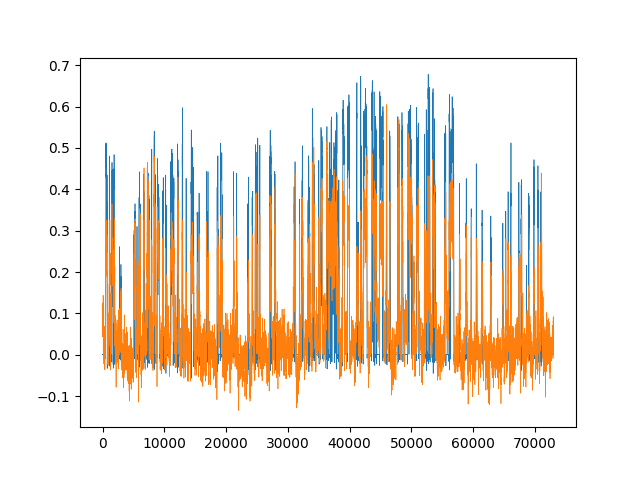

In [35]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

treadmill, train R: 0.7793351797937388
treadmill, test  R: 0.7693474367253142


<IPython.core.display.Javascript object>


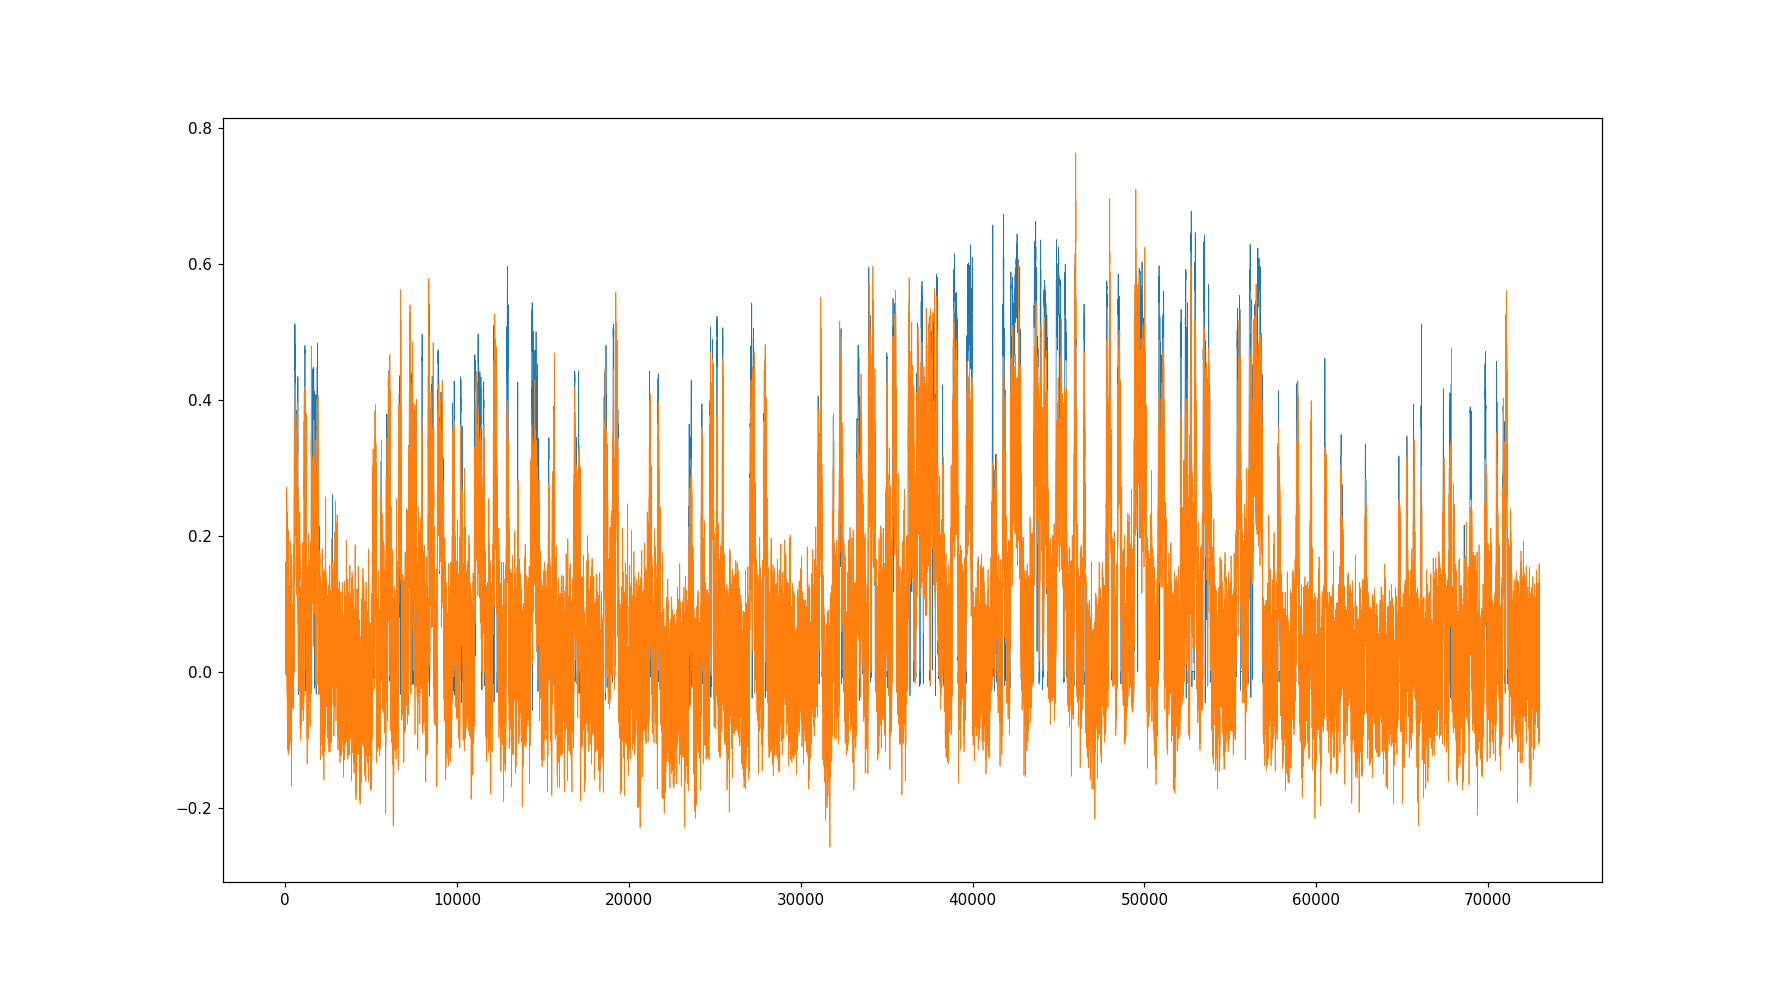

In [186]:
## Correlate to licking signal
idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
# plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

In [96]:
theta_FF.shape
F_zscore_roll[:,IsCell_ROIClassifier==True].shape

(1553, 8)

In [198]:
np.sum(IsCell_ROIClassifier)

1286.0

In [195]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 5

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


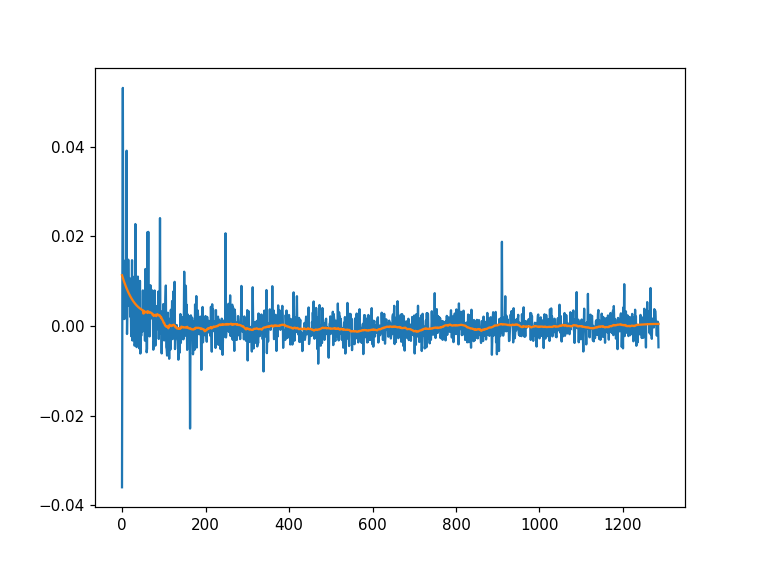

In [196]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3))